<a href="https://colab.research.google.com/github/Ankitashuk282/Tweet-Analyser/blob/main/Tweet_Analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP: Sentiment Analysis from Tweets

This project involves implementing functions for a text classifier, which I'll will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.



In [ ]:
!pip install nltk

In [ ]:
import csv  # csv reader
import nltk
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import numpy as np
import re

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text), training=True),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))


# Input and Basic preprocessing

In [ ]:
def parse_data_line(data_line):
    # Sample line would be: [1100010101, negative/positive, ----statement----]
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)

    return (data_line[1], data_line[2])

In [ ]:
# Input: a string of one statement
def pre_process(text):
    # Splitting the text on space to get words
    textList = text.split(" ")
    result = []

    for word in textList:

        # words starting with @ are usernames; don't tell anything about sentiment
        if word.startswith('@'):
          continue

        # words starting with http or www are links; don't tell anything about sentiment
        if word.startswith('http') or word.startswith('www'):
          continue

        # Emojis start with ':' and are important aspects of sentiment
        # Handling emojis here as removing all symbols, if not an emoji
        if (word.startswith(':')):
            result.append(word.lower())
            continue

        # Removing symbols from prefix and suffix of the word
        res = word.lstrip("'!@#$%^&*()-_+=[]{}|;:,.<>?/`~")
        res = res.rstrip("'!@#$%^&*()-_+=[]{}|;:,.<>?/`~ ")

        if not res:
          continue

        # Normalising words by making them lowercase
        result.append(res.lower())


        # Lemmatizing the list
        lemmatizer = WordNetLemmatizer()
        lemmatized_verbs = [lemmatizer.lemmatize(word) for word in result]

        # Using NTLK to remove stop words
        stop_words = set(stopwords.words("english"))
        # Discarding negative words as they are strong negative sentiment features
        stop_words.discard("don't")
        stop_words.discard("can't")
        stop_words.discard("would't")
        stop_words.discard("didn't")
        stop_words.discard("shouldn't")
        stop_words.discard("mustn't")
        stop_words.discard("haven't")
        stop_words.discard("wasn't")
        stop_words.discard("isn't")
        stop_words.discard("hasn't")
        stop_words.discard("wouldn't")
        filtered_result = [word for word in result if word not in stop_words]

    return filtered_result


# Basic Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens, training=False):
    # Should return a dictionary containing features as keys, and weights as values

    # Using Tfid Vectoizer for feature processing
    feature_vector = {}

    # Join all tokens to form a string; required by Tfid
    document_strings = [' '.join(tokens)]

    # TfidfVectorizer instance for both unigram and bigram ranges
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

    # Fit and transform the data
    tfidf_matrix = tfidf_vectorizer.fit_transform(document_strings)

    # Get feature names and weights
    feature_names = tfidf_vectorizer.get_feature_names_out()
    weighted_vector = tfidf_matrix.toarray()

    for i in range(len(feature_names)):
      feature_vector[feature_names[i]] = weighted_vector[0][i]
      if training:
        global_feature_dict[feature_names[i]] = 1

    return feature_vector


In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Cross-validation

In [ ]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds)

    count = 1
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))

        # Finding the range of test_set
        test_start = i
        test_end = min(i + fold_size, len(dataset))

        # Selecting test and training sets. (Test is 1/10 and training 9/10)
        test_set = dataset[test_start:test_end]
        train_set = dataset[:test_start] + dataset[test_end:]

        classifier = train_classifier(train_set)  # train the classifier on train-set
        test_true = [t[1] for t in test_set]   # get the ground-truth labels from the source data
        test_pred = predict_labels([x[0] for x in test_set], classifier)  # classify the test data to get predicted labels
        final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
        accuracy = np.mean(np.array(test_true) == np.array(test_pred))

        results.append((final_scores, accuracy))

    precision_values  = [val[0][0] for val in results]

    precision_mean = sum(precision_values) / len(results)
    recall_mean = sum([val[0][1] for val in results]) / len(results)
    fscore_mean = sum([val[0][2] for val in results]) / len(results)
    accuracy_mean = sum([val[1] for val in results]) / len(results)

    cv_results = [precision_mean, recall_mean, fscore_mean, accuracy_mean]

    return cv_results

In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


print("Sample rawData")
print(raw_data[0])
print("Sample train Data")
print(train_data[0])


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
237686
Sample rawData
("Literally so excited I'm going to a Sam Smith concert in October", 'positive')
Sample train Data
({'concert': 0.2773500981126146, 'concert october': 0.2773500981126146, 'excited': 0.2773500981126146, 'excited going': 0.2773500981126146, 'going': 0.2773500981126146, 'going sam': 0.2773500981126146, 'literally': 0.2773500981126146, 'literally excited': 0.2773500981126146, 'october': 0.2773500981126146, 'sam': 0.2773500981126146, 'sam smith': 0.2773500981126146, 'smith': 0.2773500981126146, 'smith concert': 0.2773500981126146}, 'positive')


In [ ]:
cross_validation_results = cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

print("Precision Mean: ",cross_validation_results[0])
print("Recall Mean: ", cross_validation_results[1])
print("F-score Mean: ", cross_validation_results[2])
print("Accuracy Mean: ", cross_validation_results[3])

Fold start on items 0 - 2683
Training Classifier...
Fold start on items 2683 - 5366
Training Classifier...
Fold start on items 5366 - 8049
Training Classifier...
Fold start on items 8049 - 10732
Training Classifier...
Fold start on items 10732 - 13415
Training Classifier...
Fold start on items 13415 - 16098
Training Classifier...
Fold start on items 16098 - 18781
Training Classifier...
Fold start on items 18781 - 21464
Training Classifier...
Fold start on items 21464 - 24147
Training Classifier...
Fold start on items 24147 - 26830
Training Classifier...
Fold start on items 26830 - 29513
Training Classifier...
Precision Mean:  0.870709129123651
Recall Mean:  0.8719547318130992
F-score Mean:  0.8691340739574773
Accuracy Mean:  0.8719547318130992


# Error Analysis

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()


Training Classifier...


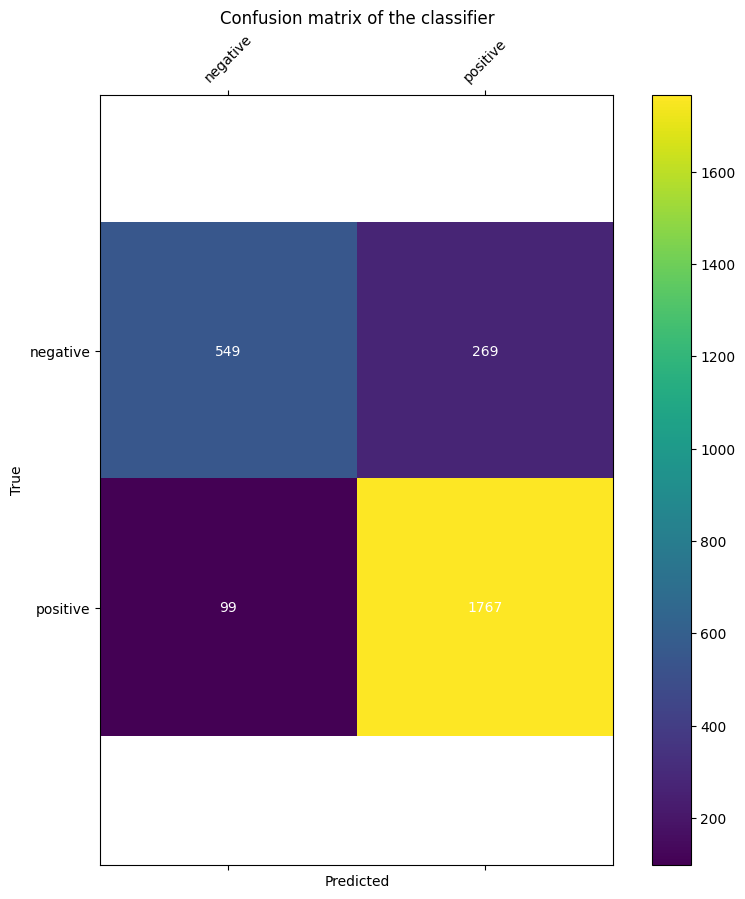

In [ ]:
labels = ['negative', 'positive']

# Selecting test and training sets. (Test is 1/10 and training 9/10)
test_set = train_data[0:2684]
train_set = train_data[2684:]

classifier = train_classifier(train_set)  # train the classifier on train-set
test_true = [t[1] for t in test_set]   # get the ground-truth labels from the source data
test_pred = predict_labels([x[0] for x in test_set], classifier)

confusion_matrix_heatmap(test_true, test_pred, labels)

# Writing the false-positives and false-negatives in a file
file_path = 'error_analysis.csv'

with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Write the heading row
    header = ['Raw Text', 'Features Extracted']
    csv_writer.writerow(header)

    header = ['------------------', '------------------']
    csv_writer.writerow(header)

    header = ['FALSE POSITIVES', '']
    csv_writer.writerow(header)


    # Write False Positives data
    for i in range(len(test_true)):
        if test_true[i] == 'negative' and test_pred[i] == 'positive':
            fp_data = [raw_data[i][0], test_set[i][0]]
            csv_writer.writerow(fp_data)

    # Bifurcation and False Negatives Header
    header = ['------------------', '------------------']
    csv_writer.writerow(header)

    header = ['FALSE NEGATIVES', '']
    csv_writer.writerow(header)


    # Write False Negatives data
    for i in range(len(test_true)):
        if test_true[i] == 'positive' and test_pred[i] == 'negative':
            fp_data = [raw_data[i][0], test_set[i][0]]
            csv_writer.writerow(fp_data)



# Optimising pre-processing and feature extraction

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'58th': 0.1796053020267749, '58th episode': 0.1796053020267749, 'beyonce': 0.1796053020267749, 'episode': 0.1796053020267749, 'episode hsonair': 0.1796053020267749, 'hsonair': 0.1796053020267749, 'hsonair profiling': 0.1796053020267749, 'll': 0.3592106040535498, 'll release': 0.1796053020267749, 'll talk': 0.1796053020267749, 'profiling': 0.1796053020267749, 'profiling we': 0.1796053020267749, 'release': 0.1796053020267749, 'release 58th': 0.1796053020267749, 'storytelling': 0.1796053020267749, 'storytelling beyonce': 0.1796053020267749, 'talk': 0.1796053020267749, 'talk storytelling': 0.1796053020267749, 'tomorrow': 0.1796053020267749, 'tomorrow we': 0.1796053020267749, 'we': 0.3592106040535498, 'we ll': 0.3592106040535498}, 'positive')
Training Classifier...
Done training!
Precision: 0.865365
Recall: 0.866428
F Score:0.864271
